# CP Distance Analysis

## Setup

Formatting

<style>
body, .jp-Notebook {
    font-family: 'Source Sans 3', serif !important;
}


table {
    font-family: 'Source Sans 3', sans-serif;
}

table td, table th {
    text-align: center !important;
}

/* Optional: keep first column left-aligned if it contains labels */
table td:first-child, table th:first-child {
    text-align: left !important;
}
</style>

### Imports

In [1]:
from warnings import simplefilter

import pandas as pd

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=DeprecationWarning)
simplefilter(action="ignore", category=FutureWarning)

import re
import textwrap
from pathlib import Path
from pyprocessmacro import Process
from statsmodels.stats.multitest import multipletests

import os
import numpy as np
import pyperclip
import statsmodels.api as sm
from matplotlib import colormaps
from scipy import stats
from IPython.display import Markdown, display
from io import StringIO
import matplotlib.pyplot as plt
from collections import defaultdict
import subprocess
from tqdm.notebook import tqdm

from reload_recursive import reload_recursive
import sys

sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")

import helpers
import utils
import regression_utils as regutils
import my_namespace

In [2]:
reload_recursive(regutils)
reload_recursive(helpers)
reload_recursive(utils)
reload_recursive(my_namespace)

import utils
from utils import load_df, zscore, get_colors
from my_namespace import *

import regression_utils as regutils
from regression_utils import (
    quick_regression,
    quick_regression2,
    residualize_vars,
    run_regressions,
)

### Load Data

#### Clinical and Volumes

In [3]:
fig_path = Path(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/figures_tables/5-CP_distance_gradient"
)
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

data_orig = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv", index_col="subid"
)
data_origT = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data_transformed.csv",
    index_col="subid",
)

data_orig = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data.csv")


MS_patients = data_orig["dz_type2"] == "MS"
NONMS_patients = data_orig["dz_type2"] == "!MS"
NIND_patients = data_orig["dz_type5"] == "NIND"
OIND_patients = data_orig["dz_type5"] == "OIND"
RMS_patients = data_orig["dz_type5"] == "RMS"
PMS_patients = data_orig["dz_type5"] == "PMS"

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
deep_grey = [13, 14, 26, 27, 28, 29, 30, 31, 32]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
hips_thomas_invref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="struct"
)["index"]

data_ms = data_orig[MS_patients]
data_ms_z = zscore(data_ms)

resid_data_z = data_ms_z.copy()
resid_data = data_ms.copy()
for var in all_predictors:
    resid_data[var] = utils.residualize_structs(data_ms, var, ["age", "Female", "tiv"])
    resid_data_z[var] = utils.residualize_structs(
        data_ms_z, var, ["age", "Female", "tiv"]
    )


grouped_nuclei = ["medial", "posterior", "ventral", "anterior"]

nuclei_rename_index = {k: f"**{k}**" for k in grouped_nuclei}

### Load Distances

In [4]:
data_dir = Path("/home/srs-9/Projects/ms_mri/data")

mean_thomas_vols = data_orig[hips_thomas_ref].rename(columns=hips_thomas_invref).mean()

# CP distances
choroid_dists_left = pd.read_csv(
    data_dir / "centroid-choroid_centroid-left.csv", index_col="subid"
)
choroid_dists_right = pd.read_csv(
    data_dir / "centroid-choroid_centroid-right.csv", index_col="subid"
)
choroid_dists = (choroid_dists_left + choroid_dists_right) / 2
new_cols = {str(i): f"{k}_CP_dist" for i, k in hips_thomas_ref.items()}
try:
    data_orig = data_orig.join([choroid_dists.rename(columns=new_cols)])
except ValueError:
    pass

mean_choroid_dists = choroid_dists.mean()
mean_choroid_dists.index = mean_choroid_dists.index.map(int)


# Ventricle SDT distances
ventricle_dists_sdt_left = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-left.csv", index_col="subid"
)
ventricle_dists_sdt_right = pd.read_csv(
    data_dir / "centroid-ventricle_SDT-right.csv", index_col="subid"
)
ventricle_sdt_dists = (ventricle_dists_sdt_right + ventricle_dists_sdt_left) / 2
new_cols = {str(i): f"{k}_LV_sdt" for i, k in hips_thomas_ref.items()}
try:
    data_orig = data_orig.join([ventricle_sdt_dists.rename(columns=new_cols)])
except ValueError:
    pass

mean_ventricle_sdt_dists = ventricle_sdt_dists.mean()
mean_ventricle_sdt_dists.index = mean_ventricle_sdt_dists.index.map(int)


# Load other MNI dists
mni_outerCSF_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_outerCSF_dists["dist"] = (
    mni_outerCSF_dists["left_exposure"] + mni_outerCSF_dists["right_exposure"]
) / 2
mni_outerCSF_dists = mni_outerCSF_dists["dist"]

test_dist = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_ventricle_shortestSDT_tmp.csv", index_col="index"
)['left_exposure']
mni_allCSF_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_allCSF_dists["dist"] = (
    mni_allCSF_dists["left_exposure"] + mni_allCSF_dists["right_exposure"]
) / 2
mni_allCSF_dists = mni_allCSF_dists["dist"]

mni_allCSF_dists_norm = mni_allCSF_dists / (mean_thomas_vols**(1/3))

mni_ventricle_dists = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/mni_outer_CSF_SDT.csv", index_col="index"
)
mni_ventricle_dists["dist"] = (
    mni_ventricle_dists["left_exposure"] + mni_ventricle_dists["right_exposure"]
) / 2
mni_ventricle_dists = mni_ventricle_dists["dist"]

mni_viewfactors = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_test1.csv", index_col="index")['dose']
mni_viewfactors_norm = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_test1_norm.csv", index_col="index")['dose']

mni_viewfactors2 = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_midlineCSF.csv", index_col="index")['dose']
mni_viewfactors2_norm = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_midlineCSF_norm.csv", index_col="index")['dose']

mni_viewfactors3 = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_ventricle_system.csv", index_col="index")['dose']
mni_viewfactors3_norm = pd.read_csv("/home/srs-9/Projects/ms_mri/data/mni_viewfactor_ventricle_system_norm.csv", index_col="index")['dose']

### Functions

In [11]:
def signed_log(x):
    return np.sign(x) * np.log10(np.abs(x) + 1)

def plot_xordered_data(
    data,
    x_name,
    y_name,
    label_name,
    loc=(0.8, 0.05),
    fit_line=False,
    fdr=False,
    xlabel=None,
    ylabel=None,
    title=None,
    axes=None,
    fig=None,
    legend=False,
    fit_params=True,
    hide_x=False,
    fontsize=10,
    legend_fontsize=10,
    bbox_to_anchor=None,
    text_x = None,
    text_y = None,
    sig_only = False,
    indicate_sig=True,
    legend_sig=False
) -> tuple:
    """_summary_

    Args:
        data (pd.DataFrame): data to plot
        x_name (str): name of column for x axis
        y_name (str): name of column for y axis
        label_name (str): name of column to use for legend labels
        **kwargs
    Returns:
        tuple: fig, axs, data, linregress_result
    """
    
    if fdr:
        p_col = "p_fdr"
    else:
        p_col = "pval"

    if xlabel is None:
        xlabel = x_name
    if ylabel is None:
        ylabel = y_name
    if title is None:
        title = f"{ylabel} vs {xlabel}"

    if axes is None:
        fig, axes = plt.subplots(1)
    data.sort_values(by=x_name, inplace=True)
    if sig_only:
        data = data[data[p_col] < 0.05]
    for i, row in data.iterrows():
        c = row[x_name] / data[x_name].max()
        if indicate_sig:
            if p_col in data.columns and data.loc[i, p_col] >= 0.05:
                marker = "x"
            else:
                marker = "D"
        else:
            marker = "D"
        if legend:
            label = data.loc[i, label_name]
            if legend_sig and p_col in data.columns and data.loc[i, p_col] < 0.05:
                label = label + "*"
        else:
            label = None
        axes.scatter(
            data.loc[i, x_name],
            data.loc[i, y_name],
            marker=marker,
            color=viridis(c),
            label=label,
        )

    xlims = axes.get_xlim()
    ylims = axes.get_ylim()

    linregress_result = stats.linregress(
        data[x_name], data[y_name]
    )
    
    slope, intercept, r_value, p_value, std_err = linregress_result
    if fit_line:
        x = np.array([xlims[0], xlims[1]])
        y = slope * x + intercept
        axes.plot(x, y, c="black")

    if fit_params:
        text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
        if text_y is None:
            text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
        if text_x is None:
            text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
        axes.text(text_x, text_y, text)

    axes.set_xbound([xlims[0], xlims[1] * 1.1])
    if legend:
        axes.legend(loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=legend_fontsize)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    if hide_x:
        axes.xaxis.set_major_formatter(plt.NullFormatter())
        axes.set_xlabel("")

    return fig, axes, data, linregress_result


def bootstrap_procedure(
    model_data,
    all_distances,
    covariates,
    predictor,
    structs,
    n_boots=1000,
    inverse_slope=False,
) -> tuple:
    df_to_sample = model_data.join(all_distances)
    df_to_sample = df_to_sample.reset_index()
    struct_i = hips_thomas_invref[structs]
    struct_str = [str(i) for i in struct_i]
    
    linregress_results = np.zeros((n_boots, 5))
    for i_samp in tqdm(range(n_boots), total=n_boots):
        inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
        sample_data = df_to_sample.loc[inds, :]
        distances = sample_data[struct_str].mean()
        new_index = [int(ind) for ind in distances.index]
        distances.index = new_index
        _, results, _ = regutils.run_regressions(
            sample_data,
            structs,
            [predictor],
            covariates,
        )
        data = results[predictor].set_index(hips_thomas_invref[structs])

        data["dist"] = distances
        res = stats.linregress(
            data["dist"], data["coef"]
        )
        linregress_results[i_samp, :] = np.array(res)
        
    return linregress_results


def bootstrap_procedure2(
    model_data,
    distances,
    covariates,
    predictor,
    structs,
    n_boots=1000,
    inverse_slope=False,
) -> tuple:
    df_to_sample = model_data.copy()
    df_to_sample = df_to_sample.reset_index()
    struct_i = hips_thomas_invref[structs]
    struct_str = [str(i) for i in struct_i]
    
    linregress_results = np.zeros((n_boots, 5))
    for i_samp in tqdm(range(n_boots), total=n_boots):
        inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
        sample_data = df_to_sample.loc[inds, :]
        _, results, _ = regutils.run_regressions(
            sample_data,
            structs,
            [predictor],
            covariates,
        )
        data = results[predictor].set_index(hips_thomas_invref[structs])

        data["dist"] = distances

        # data['dist'] = np.arcsinh(data['dist'])
        # data['coef'] = np.arcsinh(data['coef'])
        # data['dist'] = signed_log(data['dist'])
        # data['coef'] = signed_log(data['coef'])

        res = stats.linregress(
            data["dist"], data["coef"]
        )
        linregress_results[i_samp, :] = np.array(res)
        
    return linregress_results

## Analysis

### Influence of CP Decreases with Distance

To better understand the relationship between CP volume and localized atrophy, we regressed all thalamic nuclei and deep grey volumes on CP volume, with peripheral CSF fraction as an additional covariate to isolate central effects. We plotted the standardized coefficients for deep grey and thalamic volumes with respect to CP volume against each structure’s distance from the CP

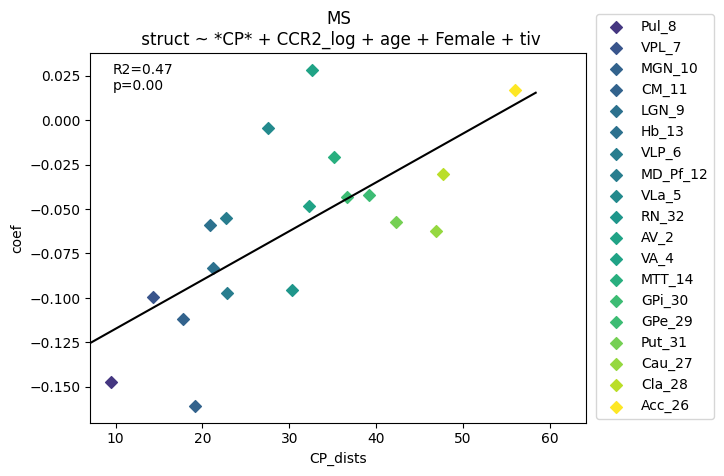

In [10]:
save = False
show = True
sig_only = False
save_stem = "CP_betas_vs_CP_dists"

# model_data = data_ms_z
model_data = data_orig[MS_patients]
model_data = zscore(model_data)

covariates = ["CCR2_log", "age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]
# structs = hips_thomas_ref[thalamic_nuclei]

predictor = ["CP", "LV_log", "CCR2_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
    robust_cov="nonrobust"
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data['viewfactors'] = mni_viewfactors
data['viewfactors_norm'] = mni_viewfactors_norm

dist_measure = "CP_dists"

fig, axes = plt.subplots()
axs = axes
_, _, plot_data, linregress_result = plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=sig_only,
    indicate_sig=False,
    legend_fontsize=10
)
plt.show()

if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


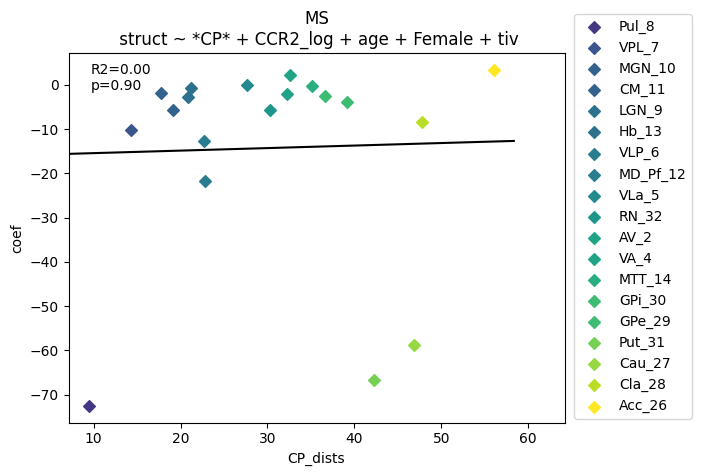

In [7]:
save = False
show = True
sig_only = False
save_stem = "CP_betas_vs_CP_dists"

structs = hips_thomas_ref[thalamic_nuclei + deep_grey]
# model_data = data_ms_z
model_data = data_orig[MS_patients]
model_data = zscore(model_data, skip_vars=structs)

covariates = ["CCR2_log", "age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
# structs = hips_thomas_ref[thalamic_nuclei]

predictor = ["CP", "LV_log", "CCR2_log"]

# _, results, formulas = regutils.run_regressions(
#     model_data,
#     structs,
#     predictor,
#     covariates,
#     robust_cov="nonrobust"
# )

_, results, formulas = regutils.run_partial_regressions(
    model_data,
    structs.to_list(),
    predictor,
    covariates,
    robust_cov="nonrobust"
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data['viewfactors'] = mni_viewfactors
data['viewfactors_norm'] = mni_viewfactors_norm

dist_measure = "CP_dists"

fig, axes = plt.subplots()
axs = axes
_, _, plot_data, linregress_result = plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=sig_only,
    indicate_sig=False,
    legend_fontsize=10
)
plt.show()

if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


#### Bootstrap to assess stability 

In [160]:
load_bootstrap = True
bootstrap_result_path = fig_path / "basic_covariates_bootstrap_results.npy"

if load_bootstrap:
    bootstrap_results = np.load(bootstrap_result_path)
else:
    bootstrap_results = bootstrap_procedure(
        model_data, choroid_dists, covariates, var_to_plot, structs
    )
    np.save(bootstrap_result_path, bootstrap_results)

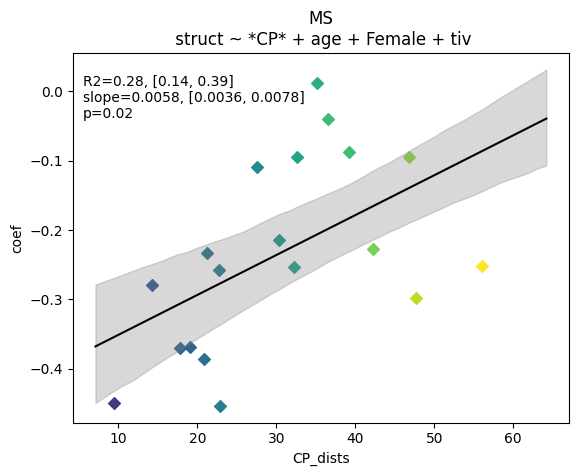

<Figure size 200x400 with 0 Axes>

In [162]:
save = True

slopes = bootstrap_results[:, 0]
intercepts = bootstrap_results[:, 1]
r_values = bootstrap_results[:, 2]


fig, axs = plt.subplots()
_, _, _, linregress_result = plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=False,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    text_y = 0.07,
    fit_params=False,
    indicate_sig=False,
    legend_sig=True
)

xlims = axs.get_xlim()
ylims = axs.get_ylim()

r2 = linregress_result.rvalue**2
r2_values = np.sort(r_values**2)

slope = linregress_result.slope
sorted_slopes = np.sort(slopes)

p_val = linregress_result.pvalue

fit_text = f"""R2={r2:0.2f}, [{r2_values[25]:0.2f}, {r2_values[975]:0.2f}]
slope={slope:0.2}, [{sorted_slopes[25]:0.2}, {sorted_slopes[975]:0.2}]
p={p_val:0.2f}
"""

x_range = np.linspace(xlims[0], xlims[1])
y = x_range*slope + linregress_result.intercept
axs.plot(x_range, y, c="black")

y_boot = intercepts + slopes*x_range[:, np.newaxis]
y_boot.sort()
y_low = y_boot[:, 25]
y_high = y_boot[:, 975]

axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")

xlims_final = axs.get_xlim()
ylims_final = axs.get_ylim()

text_y = ylims_final[0] + (ylims_final[1] - ylims_final[0]) * 0.78
text_x = xlims_final[0] + (xlims_final[1] - xlims_final[0]) * 0.02
axs.text(text_x, text_y, fit_text)

if save:
    save_path = fig_path / f"{save_stem}_bootstrap.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_bootstrap_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(save_path, bbox_inches='tight', dpi=300)


### Use an additional covariate to isolate CP's effect

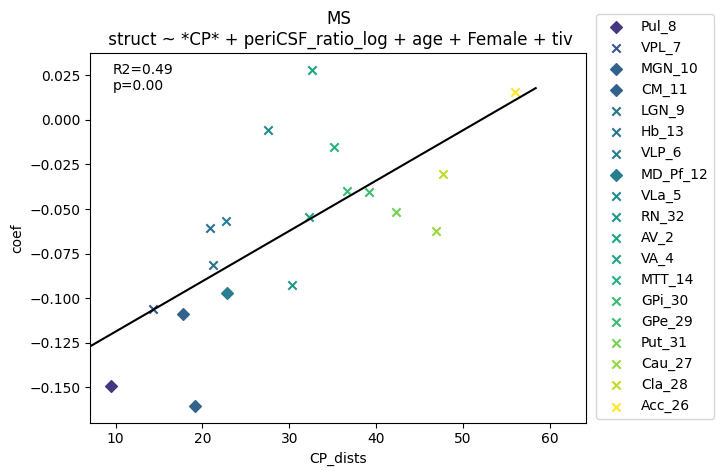

In [177]:
save = False
show = True
sig_only = False
save_stem = "CP_betas_vs_CP_dists_control_periCSF_ratio"

# model_data = data_ms_z
model_data = data_orig[MS_patients]
model_data = zscore(model_data)

covariates = ["periCSF_ratio_log", "age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]
# structs = hips_thomas_ref[thalamic_nuclei]

predictor = ["CP", "LV_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
    robust_cov=None
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data['viewfactors'] = mni_viewfactors
data['viewfactors_norm'] = mni_viewfactors_norm

dist_measure = "CP_dists"

fig, axes = plt.subplots()
axs = axes
_, _, plot_data, linregress_result = plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=sig_only,
    legend_fontsize=10
)
plt.show()

if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


In [151]:
load_bootstrap = False
bootstrap_result_path = fig_path / "periCSF_ratio_control_bootstrap_results.npy"

if load_bootstrap:
    bootstrap_results = np.load(bootstrap_result_path)
else:
    print(covariates)
    print(var_to_plot)
    bootstrap_results = bootstrap_procedure(
        model_data, choroid_dists, covariates, var_to_plot, structs
    )
    np.save(bootstrap_result_path, bootstrap_results)

['periCSF_ratio_log', 'age', 'Female', 'tiv']
CP


  0%|          | 0/1000 [00:00<?, ?it/s]

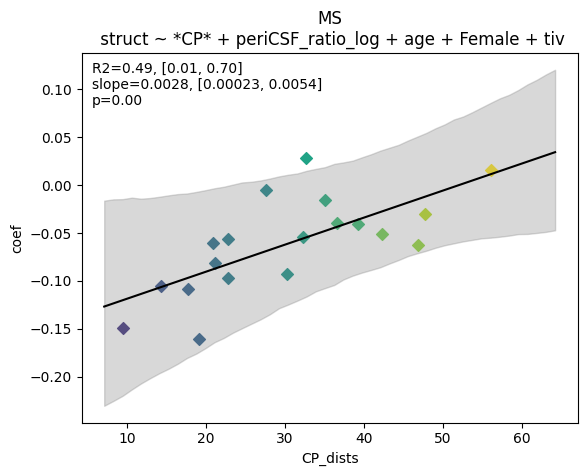

<Figure size 200x400 with 0 Axes>

In [155]:
save = True

slopes = bootstrap_results[:, 0]
intercepts = bootstrap_results[:, 1]
r_values = bootstrap_results[:, 2]


fig, axs = plt.subplots()
_, _, _, linregress_result = plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=False,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    text_y = 0.07,
    fit_params=False,
    indicate_sig=False,
    legend_sig=True
)

xlims = axs.get_xlim()
ylims = axs.get_ylim()

r2 = linregress_result.rvalue**2
r2_values = np.sort(r_values**2)

slope = linregress_result.slope
sorted_slopes = np.sort(slopes)

p_val = linregress_result.pvalue

fit_text = f"""R2={r2:0.2f}, [{r2_values[25]:0.2f}, {r2_values[975]:0.2f}]
slope={slope:0.2}, [{sorted_slopes[25]:0.2}, {sorted_slopes[975]:0.2}]
p={p_val:0.2f}
"""

x_range = np.linspace(xlims[0], xlims[1])
y = x_range*slope + linregress_result.intercept
axs.plot(x_range, y, c="black")

y_boot = intercepts + slopes*x_range[:, np.newaxis]
y_boot.sort()
y_low = y_boot[:, 25]
y_high = y_boot[:, 975]

axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")

xlims_final = axs.get_xlim()
ylims_final = axs.get_ylim()

text_y = ylims_final[0] + (ylims_final[1] - ylims_final[0]) * 0.815
text_x = xlims_final[0] + (xlims_final[1] - xlims_final[0]) * 0.02
axs.text(text_x, text_y, fit_text)

if save:
    save_path = fig_path / f"{save_stem}_bootstrap.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_bootstrap_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


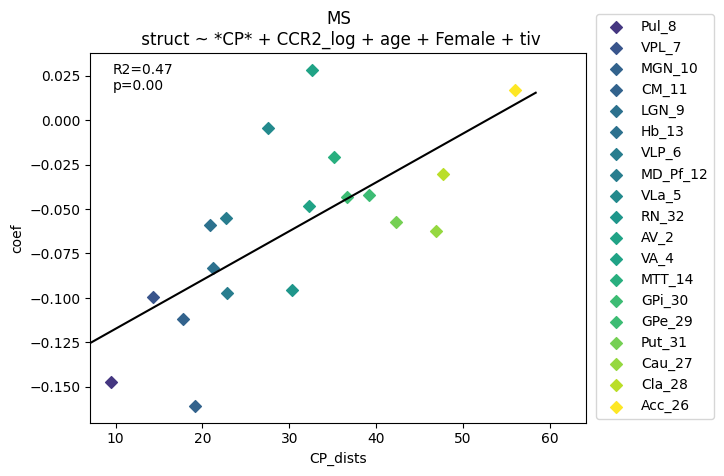

In [11]:
save = False
show = True
sig_only = False
save_stem = "CP_betas_vs_CP_dists"

# model_data = data_ms_z
model_data = data_orig[MS_patients]
model_data = zscore(model_data)

covariates = ["CCR2_log", "age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]
# structs = hips_thomas_ref[thalamic_nuclei]

predictor = ["CP", "LV_log", "CCR2_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
    robust_cov="nonrobust"
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data['viewfactors'] = mni_viewfactors
data['viewfactors_norm'] = mni_viewfactors_norm

dist_measure = "CP_dists"

fig, axes = plt.subplots()
axs = axes
_, _, plot_data, linregress_result = plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=sig_only,
    indicate_sig=False,
    legend_fontsize=10
)
plt.show()

if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


In [12]:
load_bootstrap = False
bootstrap_result_path = fig_path / "CCR2_control_bootstrap_results.npy"

if load_bootstrap:
    bootstrap_results = np.load(bootstrap_result_path)
else:
    print(covariates)
    print(var_to_plot)
    bootstrap_results = bootstrap_procedure(
        model_data, choroid_dists, covariates, var_to_plot, structs
    )
    np.save(bootstrap_result_path, bootstrap_results)

['CCR2_log', 'age', 'Female', 'tiv']
CP


  0%|          | 0/1000 [00:00<?, ?it/s]

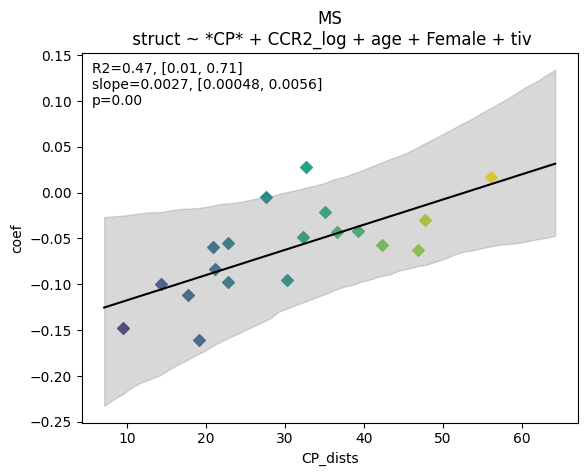

<Figure size 200x400 with 0 Axes>

In [13]:
save = True

slopes = bootstrap_results[:, 0]
intercepts = bootstrap_results[:, 1]
r_values = bootstrap_results[:, 2]


fig, axs = plt.subplots()
_, _, _, linregress_result = plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=False,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    text_y = 0.07,
    fit_params=False,
    indicate_sig=False,
    legend_sig=True
)

xlims = axs.get_xlim()
ylims = axs.get_ylim()

r2 = linregress_result.rvalue**2
r2_values = np.sort(r_values**2)

slope = linregress_result.slope
sorted_slopes = np.sort(slopes)

p_val = linregress_result.pvalue

fit_text = f"""R2={r2:0.2f}, [{r2_values[25]:0.2f}, {r2_values[975]:0.2f}]
slope={slope:0.2}, [{sorted_slopes[25]:0.2}, {sorted_slopes[975]:0.2}]
p={p_val:0.2f}
"""

x_range = np.linspace(xlims[0], xlims[1])
y = x_range*slope + linregress_result.intercept
axs.plot(x_range, y, c="black")

y_boot = intercepts + slopes*x_range[:, np.newaxis]
y_boot.sort()
y_low = y_boot[:, 25]
y_high = y_boot[:, 975]

axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")

xlims_final = axs.get_xlim()
ylims_final = axs.get_ylim()

text_y = ylims_final[0] + (ylims_final[1] - ylims_final[0]) * 0.815
text_x = xlims_final[0] + (xlims_final[1] - xlims_final[0]) * 0.02
axs.text(text_x, text_y, fit_text)

if save:
    save_path = fig_path / f"{save_stem}_bootstrap.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_bootstrap_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


### Just the thalamus

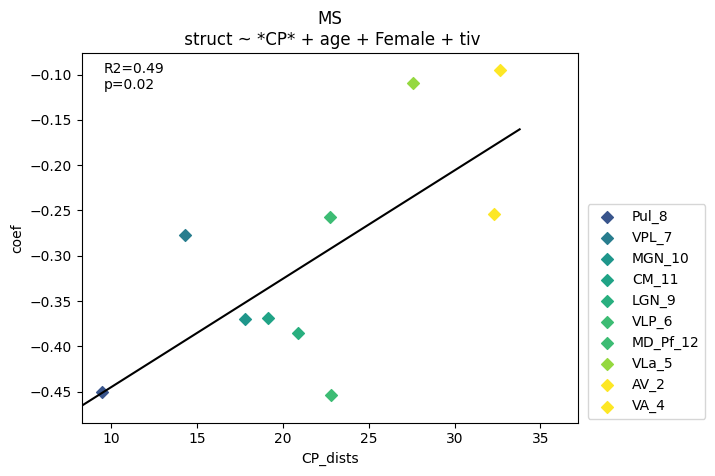

In [15]:
save = False
show = True
sig_only = False
save_stem = "CP_betas_vs_CP_dists_thalamus"

# model_data = data_ms_z
model_data = data_orig[MS_patients]
model_data = zscore(model_data)

covariates = ["age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei]

predictor = ["CP", "LV_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
    robust_cov="nonrobust"
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data['viewfactors'] = mni_viewfactors
data['viewfactors_norm'] = mni_viewfactors_norm

dist_measure = "CP_dists"

fig, axes = plt.subplots()
axs = axes
_, _, plot_data, linregress_result = plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=sig_only,
    legend_fontsize=10
)
plt.show()

if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


In [164]:
load_bootstrap = False
bootstrap_result_path = fig_path / "just_thalamus_basic_covariates_bootstrap_results.npy"

if load_bootstrap:
    bootstrap_results = np.load(bootstrap_result_path)
else:
    print(covariates)
    print(var_to_plot)
    bootstrap_results = bootstrap_procedure(
        model_data, choroid_dists, covariates, var_to_plot, structs
    )
    np.save(bootstrap_result_path, bootstrap_results)

['age', 'Female', 'tiv']
CP


  0%|          | 0/1000 [00:00<?, ?it/s]

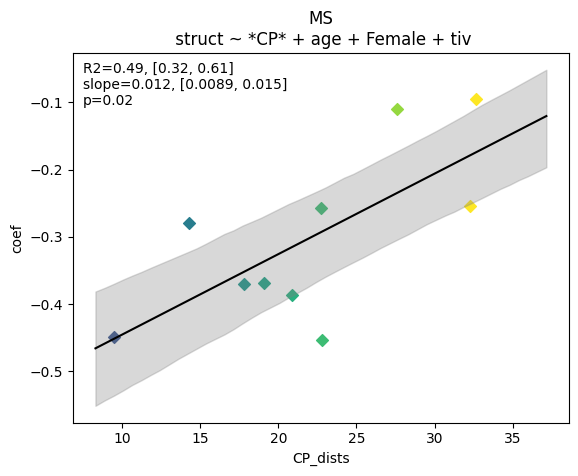

<Figure size 200x400 with 0 Axes>

In [166]:
save = True

slopes = bootstrap_results[:, 0]
intercepts = bootstrap_results[:, 1]
r_values = bootstrap_results[:, 2]


fig, axs = plt.subplots()
_, _, _, linregress_result = plot_xordered_data(
    data,
    "CP_dists",
    "coef",
    "struct",
    fit_line=False,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    text_y = 0.07,
    fit_params=False,
    indicate_sig=False,
    legend_sig=True
)

xlims = axs.get_xlim()
ylims = axs.get_ylim()

r2 = linregress_result.rvalue**2
r2_values = np.sort(r_values**2)

slope = linregress_result.slope
sorted_slopes = np.sort(slopes)

p_val = linregress_result.pvalue

fit_text = f"""R2={r2:0.2f}, [{r2_values[25]:0.2f}, {r2_values[975]:0.2f}]
slope={slope:0.2}, [{sorted_slopes[25]:0.2}, {sorted_slopes[975]:0.2}]
p={p_val:0.2f}
"""

x_range = np.linspace(xlims[0], xlims[1])
y = x_range*slope + linregress_result.intercept
axs.plot(x_range, y, c="black")

y_boot = intercepts + slopes*x_range[:, np.newaxis]
y_boot.sort()
y_low = y_boot[:, 25]
y_high = y_boot[:, 975]

axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")

xlims_final = axs.get_xlim()
ylims_final = axs.get_ylim()

text_y = ylims_final[0] + (ylims_final[1] - ylims_final[0]) * 0.815
text_x = xlims_final[0] + (xlims_final[1] - xlims_final[0]) * 0.02
axs.text(text_x, text_y, fit_text)

if save:
    save_path = fig_path / f"{save_stem}_bootstrap.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_bootstrap_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


---

## Extras

In [56]:
def signed_log(x):
    return np.sign(x) * np.log10(np.abs(x) + 1)

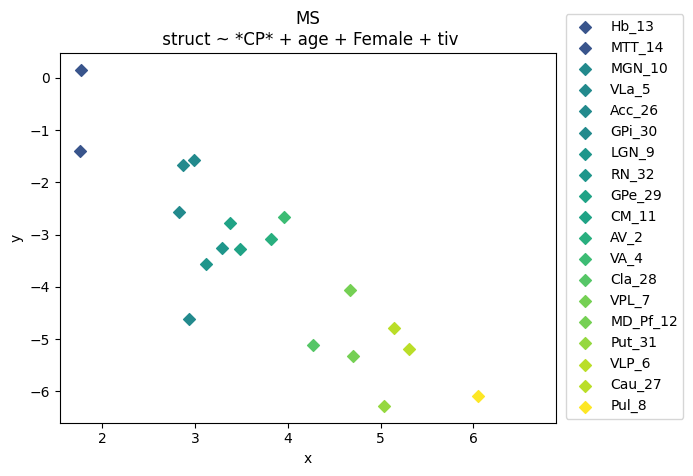

In [26]:
save = False
show = True
sig_only = False
save_stem = "CP_betas_vs_CP_dists"

structs = hips_thomas_ref[thalamic_nuclei + deep_grey]
# structs = structs[~structs.isin(["Pul_8", "Cau_27", "Put_31"])]
# model_data = data_ms_z
model_data = data_orig[MS_patients]
model_data = zscore(model_data, skip_vars=structs)
# model_data = zscore(model_data)

covariates = ["age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
# structs = hips_thomas_ref[thalamic_nuclei]

predictor = ["CP", "LV_log", "CCR2_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
    robust_cov="nonrobust"
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data['viewfactors'] = mni_viewfactors
data['viewfactors_log'] = np.log(mni_viewfactors)
data['viewfactors_norm'] = mni_viewfactors_norm
data['coef_log'] = np.log1p(data['coef'] - data['coef'].min())
data['mni_ventricle'] = mni_ventricle_dists


dist_measure = "viewfactors"
data['x'] = np.arcsinh(data[dist_measure])
data['y'] = np.arcsinh(data['coef'])
# data['x'] = data[dist_measure]
# data['y'] = data['coef']
# data['x'] = signed_log(data[dist_measure])
# data['y'] = signed_log(data['coef'])

fig, axes = plt.subplots()
axs = axes
_, _, plot_data, linregress_result = plot_xordered_data(
    data,
    "x",
    "y",
    "struct",
    fit_line=False,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=sig_only,
    indicate_sig=False,
    legend_fontsize=10,
    fit_params=False
)
plt.show()

if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


In [12]:
load_bootstrap = False
bootstrap_result_path = fig_path / "basic_covariates_bootstrap_results_viewfactors.npy"

if load_bootstrap:
    bootstrap_results = np.load(bootstrap_result_path)
else:
    bootstrap_results = bootstrap_procedure2(
        model_data, mni_viewfactors, covariates, var_to_plot, structs
    )
    np.save(bootstrap_result_path, bootstrap_results)

  0%|          | 0/1000 [00:00<?, ?it/s]

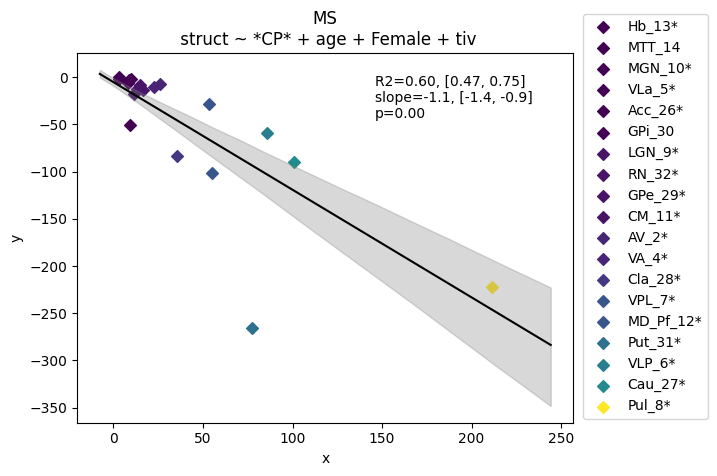

In [23]:
save = False

slopes = bootstrap_results[:, 0]
intercepts = bootstrap_results[:, 1]
r_values = bootstrap_results[:, 2]

data["CP_dists"] = mean_choroid_dists
data['viewfactors'] = mni_viewfactors
data['viewfactors_log'] = np.log(mni_viewfactors)
data['viewfactors_norm'] = mni_viewfactors_norm
data['coef_log'] = np.log1p(data['coef'] - data['coef'].min())
data['mni_ventricle'] = mni_ventricle_dists


dist_measure = "viewfactors"
# data['x'] = np.arcsinh(data[dist_measure])
# data['y'] = np.arcsinh(data['coef'])
data['x'] = data[dist_measure]
data['y'] = data['coef']
# data['x'] = signed_log(data[dist_measure])
# data['y'] = signed_log(data['coef'])



fig, axs = plt.subplots()
_, _, _, linregress_result = plot_xordered_data(
    data,
    'x',
    'y',
    "struct",
    fit_line=False,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    text_y = 0.07,
    fit_params=False,
    indicate_sig=False,
    legend_sig=True,
)

xlims = axs.get_xlim()
ylims = axs.get_ylim()

r2 = linregress_result.rvalue**2
r2_values = np.sort(r_values**2)

slope = linregress_result.slope
sorted_slopes = np.sort(slopes)

p_val = linregress_result.pvalue

fit_text = f"""R2={r2:0.2f}, [{r2_values[25]:0.2f}, {r2_values[975]:0.2f}]
slope={slope:0.2}, [{sorted_slopes[25]:0.2}, {sorted_slopes[975]:0.2}]
p={p_val:0.2f}
"""

# x_range = np.linspace(data[dist_measure].min(), data[dist_measure].max())
x_range = np.linspace(xlims[0], xlims[1])
y = x_range*slope + linregress_result.intercept
y_boot = intercepts + slopes*x_range[:, np.newaxis]

# x_range = np.arcsinh(x_range)
# y = np.arcsinh(y)
# y_boot = np.arcsinh(y_boot)

y_boot.sort()
y_low = y_boot[:, 25]
y_high = y_boot[:, 975]


axs.plot(x_range, y_boot.mean(axis=1), c="black")
axs.fill_between(x_range, y_low, y_high, alpha=0.3, color="gray")

xlims_final = axs.get_xlim()
ylims_final = axs.get_ylim()

text_y = ylims_final[0] + (ylims_final[1] - ylims_final[0]) * 0.78
text_x = xlims_final[1] - (xlims_final[1] - xlims_final[0]) * 0.4
axs.text(text_x, text_y, fit_text)

if save:
    save_path = fig_path / f"{save_stem}_bootstrap_viewfactors.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_bootstrap_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(save_path, bbox_inches='tight', dpi=300)


In [39]:
x_range_trans

array([1.75724138, 2.65431636, 3.12280376, 3.44102607, 3.68218518,
       3.87638947, 4.03896567, 4.17878237, 4.30143399, 4.41067683,
       4.50915518, 4.59880102, 4.68106886, 4.75708115, 4.82772225,
       4.8937013 , 4.95559569, 5.01388178, 5.06895716, 5.12115714,
       5.17076712, 5.21803197, 5.26316345, 5.30634582, 5.3477405 ,
       5.38748962, 5.42571903, 5.46254066, 5.49805452, 5.53235032,
       5.56550884, 5.59760311, 5.62869931, 5.65885765, 5.68813305,
       5.71657574, 5.74423179, 5.77114353, 5.79734998, 5.82288717,
       5.84778842, 5.87208465, 5.89580456, 5.91897485, 5.94162043,
       5.96376452, 5.98542886, 6.0066338 , 6.02739842, 6.04774063])

## Scratch

In [175]:
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]
predictor = ["periCSF_ratio_log", "CCR"]
covariates = ["age", "Female", "tiv"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
    robust_cov=None
)

results['CCR']

,coef,pval,p_fdr,se,llci,ulci,ci,R2,formula,coef_sig
outcome,,,,,,,,,,
AV_2,-0.321655,9.566182e-14,1.652341e-13,0.041881,-0.403955,-0.239355,"[-0.404, -0.239]",0.313380,AV_2 ~ CCR + age + Female + tiv,NaN
VA_4,-0.178618,2.134140e-06,2.703244e-06,0.037203,-0.251726,-0.105510,"[-0.252, -0.106]",0.455221,VA_4 ~ CCR + age + Female + tiv,NaN
VLa_5,-0.187585,2.127166e-06,2.703244e-06,0.039065,-0.264352,-0.110818,"[-0.264, -0.111]",0.402585,VLa_5 ~ CCR + age + Female + tiv,NaN
VLP_6,-0.345441,7.376528e-18,1.751925e-17,0.038506,-0.421109,-0.269773,"[-0.421, -0.27]",0.420349,VLP_6 ~ CCR + age + Female + tiv,NaN
VPL_7,-0.323573,2.068704e-14,3.930537e-14,0.040963,-0.404070,-0.243077,"[-0.404, -0.243]",0.343998,VPL_7 ~ CCR + age + Female + tiv,NaN
Pul_8,-0.516091,7.034195e-35,6.682485e-34,0.038476,-0.591700,-0.440482,"[-0.592, -0.44]",0.418401,Pul_8 ~ CCR + age + Female + tiv,NaN
LGN_9,-0.497565,3.773671e-29,1.792494e-28,0.041392,-0.578905,-0.416224,"[-0.579, -0.416]",0.330268,LGN_9 ~ CCR + age + Female + tiv,NaN
MGN_10,-0.435628,2.808278e-28,1.067146e-27,0.036911,-0.508163,-0.363093,"[-0.508, -0.363]",0.467399,MGN_10 ~ CCR + age + Female + tiv,NaN
CM_11,-0.412649,2.035174e-24,5.524043e-24,0.038189,-0.487694,-0.337604,"[-0.488, -0.338]",0.429201,CM_11 ~ CCR + age + Female + tiv,NaN


### Test different distance measures

In [ ]:
save = False
show = True
save_stem = "CP_betas_vs_CP_dists"

# model_data = data_ms_z
model_data = data_orig[MS_patients]
model_data = zscore(model_data)

covariates = ["age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]
# structs = hips_thomas_ref[thalamic_nuclei]

predictor = ["CP", "LV_log"]

_, results, formulas = regutils.run_regressions(
    model_data,
    structs,
    predictor,
    covariates,
    robust_cov=None
)

var_to_plot = "CP"
data = results[var_to_plot]
data.set_index(hips_thomas_invref[structs], inplace=True)
data.insert(1, "struct", hips_thomas_ref)

data["CP_dists"] = mean_choroid_dists
data["allCSF_dists"] = mni_allCSF_dists
data["allCSF_dists_norm"] = mni_allCSF_dists_norm
data["outerCSF_dists"] = mni_outerCSF_dists
data["ventricle_SDT_dist"] = mean_ventricle_sdt_dists
data["ventricle_centroid_dist"] = mean_ventricle_sdt_dists

data["test_dist"] = test_dist
data['viewfactors'] = mni_viewfactors
data['viewfactors_norm'] = mni_viewfactors_norm
data['viewfactors2_norm'] = mni_viewfactors2_norm
data['viewfactors3_norm'] = mni_viewfactors3_norm



dist_measure = "CP_dists"

display(Markdown("#### Remove points that weren't significant"))
fig, axes = plt.subplots()
axs = axes
_, _, plot_data = plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=True,
    legend_fontsize=10
)
plt.show()
sig_structs = plot_data.index

fig, axes = plt.subplots()
axs = axes
plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=False,
    legend_fontsize=9
)
display(Markdown("#### Keep all points"))


if save:
    save_path = fig_path / f"{save_stem}.png"
    # # Extract the legend
    legend = axs.get_legend()
    legend.remove()  # Remove it from the main plot

    fig_legend = plt.figure(figsize=(2, 4))  # Adjust size as needed
    fig_legend.legend(handles=legend.legend_handles, labels=[t.get_text() for t in legend.get_texts()], 
                    loc='center', frameon=False)
    fig_legend.savefig(fig_path / f"{save_stem}_legend.png", bbox_inches='tight', dpi=300)

    # Save the main plot without legend
    fig.savefig(fig_path / f"{save_stem}.png", bbox_inches='tight', dpi=300)


### Try it out with partial correlation coefficients

Turns out this looks mostly similar

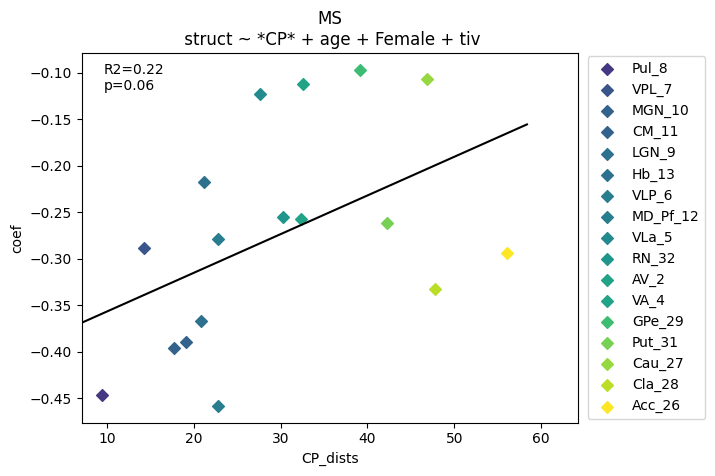

In [25]:
model_data = data_orig[MS_patients]
model_data = zscore(model_data)

covariates = ["age", "Female", "tiv"]
covariates_str = " + ".join(covariates)
structs = hips_thomas_ref[thalamic_nuclei + deep_grey]

residualized_vars = {}
for var in structs.tolist() + ["CP"]:
    residualized_vars[var] = residualize_vars(
        model_data,
        dependent_var=var,
        independent_vars=covariates,
    )

residualized_vars = pd.DataFrame(residualized_vars).dropna()

data = defaultdict(list)
index = []
for struct in structs:
    index.append(hips_thomas_invref[struct])
    data['struct'].append(struct)
    pearson_res = stats.pearsonr(residualized_vars[struct], residualized_vars['CP'])
    data['coef'].append(pearson_res.statistic)
    data['pval'].append(pearson_res.pvalue)
    data['CP_dists'].append(mean_choroid_dists[hips_thomas_invref[struct]])

data = pd.DataFrame(data, index=index)
data['p_fdr'] = stats.false_discovery_control(data['pval'])

dist_measure = "CP_dists"
var_to_plot = "CP"

fig, axes = plt.subplots()
axs = axes
_, _, plot_data = plot_xordered_data(
    data,
    dist_measure,
    "coef",
    "struct",
    fit_line=True,
    title=f"MS\n struct ~ *{var_to_plot}* + {covariates_str}",
    axes=axs,
    fig=fig,
    legend=True,
    loc=(0.9, 0.0001),
    fdr=False,
    bbox_to_anchor=(1.02, 0.01),
    sig_only=True,
    legend_fontsize=10
)
plt.show()


In [187]:
model_data['periCSF_frac'].dropna()

subid
1001    0.926322
1002    0.948842
1003    0.902969
1004    0.963339
1005    0.869965
          ...   
3016    0.912787
3017    0.962968
3021    0.885311
3023    0.867592
3028    0.863441
Name: periCSF_frac, Length: 467, dtype: float64

In [185]:
print(model_data['periCSF_frac'].min(), model_data['periCSF_frac'].max())

0.7361189344670308 0.9838657186574448
